In [1]:
from PIL import Image
from matplotlib import pyplot as plt
# %matplotlib notebook
import seaborn as sns
import os
import sys
sys.path.append("..")
sys.path.append("../src")

import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import utils
import shell

%matplotlib inline


In [2]:
def get_class_folders_from_main_directory(directory):
    sub_folders = next(os.walk(directory))[1]
    classes = sub_folders.copy()
    for i in range(len(sub_folders)):
        sub_folders[i] = os.path.join(directory, sub_folders[i])
    return sorted(sub_folders), classes

def extract_classes_sub_folder(sub_folders):
    all_image_filepaths = np.array([])
    class_array = np.array([])
    for i in range(len(sub_folders)):
        image_files = os.listdir(sub_folders[i])
        image_filepaths = list(map(lambda x : os.path.join(sub_folders[i], x), image_files))
        new_image_filepaths = []
        for j in image_filepaths:
            try:
                Image.open(j)
                new_image_filepaths.append(j)
            except:
                continue
        all_image_filepaths = np.append(all_image_filepaths, new_image_filepaths)
        class_array = np.append(class_array, [i] * len(new_image_filepaths))
#         all_image_filepaths = np.append(all_image_filepaths, image_filepaths)
#         class_array = np.append(class_array, [i] * len(image_filepaths))
    return all_image_filepaths, class_array.astype(np.int32)

In [3]:
class ImageGenerator():
    def __init__(self, filepath_array, class_array, batch_size, target_size):
        self.filepath_array = filepath_array
        self.class_array = class_array
        self.batch_size = batch_size
        self.target_size = target_size
        self.steps = len(self.class_array) // self.batch_size
        self.index = 0
        print("Found {} images with {} classes!".format(self.__len__(), len(np.unique(self.class_array))))
    
    def __iter__(self):
        return self
    
    def __len__(self):
        assert(len(self.class_array) == len(self.filepath_array))
        return len(self.class_array)
    
    def __next__(self):
        if self.index == self.__len__():
            raise StopIteration
        elif self.index + self.batch_size >= self.__len__():
            batch_filepaths = self.filepath_array[self.index : self.__len__()]
            batch_images = np.array([np.asarray(Image.open(i).convert("RGB").resize(self.target_size))[..., :3] for i in batch_filepaths]).astype(np.float32)
            batch_images = preprocess_input(batch_images)
            batch_classes = self.class_array[self.index : self.__len__()]
            self.index = self.__len__()
            return (batch_images, batch_filepaths, batch_classes)
        else:
            batch_filepaths = self.filepath_array[self.index : self.index + self.batch_size]
            batch_images = np.array([np.asarray(Image.open(i).convert("RGB").resize(self.target_size))[..., :3] for i in batch_filepaths]).astype(np.float32)
            batch_images = preprocess_input(batch_images)
            batch_classes = self.class_array[self.index : self.index + self.batch_size]
            self.index += self.batch_size
            return (batch_images, batch_filepaths, batch_classes)

In [4]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    intermediate_model = Model(inputs=main_model.input, outputs=main_model.get_layer(index=ending_layer_ix).output)
    avg_pool = GlobalAvgPool2D()(intermediate_model.layers[-1].output)
    new_model = Model(inputs=intermediate_model.input, outputs=[avg_pool])
    return new_model

# Experiment start

Main variables

In [5]:
train_dataset_directory = "../data/stl-10/train"
test_dataset_directory = "../data/stl-10/test"

In [6]:
train_sub_folders, train_classes = get_class_folders_from_main_directory(train_dataset_directory)
X_train, y_train = extract_classes_sub_folder(train_sub_folders)

In [7]:
test_sub_folders, test_classes = get_class_folders_from_main_directory(test_dataset_directory)
X_test, y_test = extract_classes_sub_folder(test_sub_folders)

In [8]:
train_image_generator = ImageGenerator(X_train, y_train, 2048, (224, 224))
test_image_generator = ImageGenerator(X_test, y_test, 1, (224, 224))

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


In [9]:
shell_family = shell.ShellFamily()
shell_family.create_preprocessor("resnet50")

In [10]:
out_layer_index = []
for layer in shell_family.preprocessor.layers[0].layers:
    if '_out' in layer.name:
        out_layer_index.append((shell_family.preprocessor.layers[0].layers.index(layer), layer.name))

In [11]:
out_layer_index

[(18, 'conv2_block1_out'),
 (28, 'conv2_block2_out'),
 (38, 'conv2_block3_out'),
 (50, 'conv3_block1_out'),
 (60, 'conv3_block2_out'),
 (70, 'conv3_block3_out'),
 (80, 'conv3_block4_out'),
 (92, 'conv4_block1_out'),
 (102, 'conv4_block2_out'),
 (112, 'conv4_block3_out'),
 (122, 'conv4_block4_out'),
 (132, 'conv4_block5_out'),
 (142, 'conv4_block6_out'),
 (154, 'conv5_block1_out'),
 (164, 'conv5_block2_out'),
 (174, 'conv5_block3_out')]

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


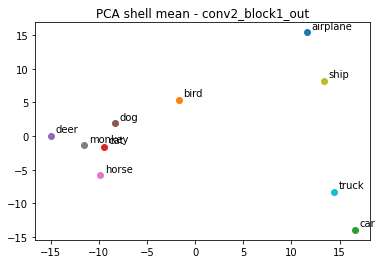

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


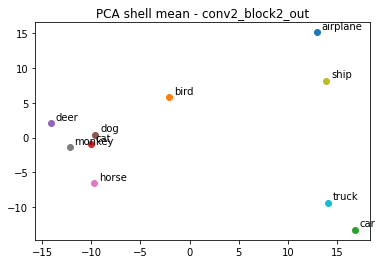

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


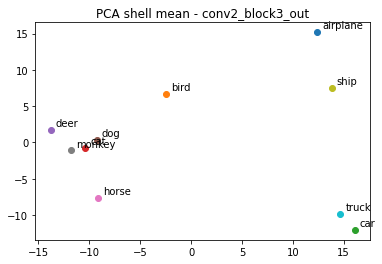

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


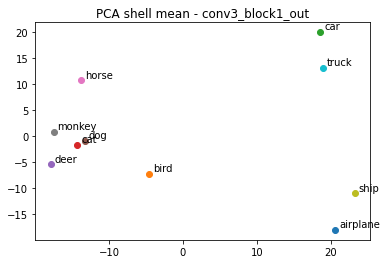

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


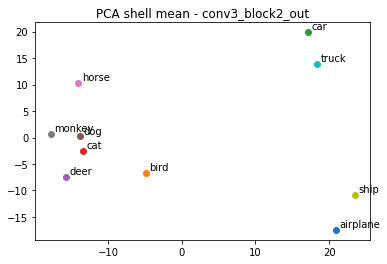

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


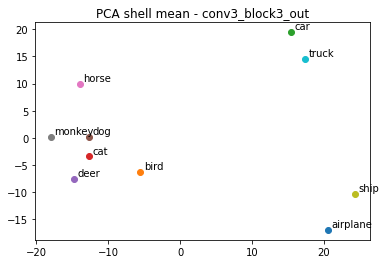

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


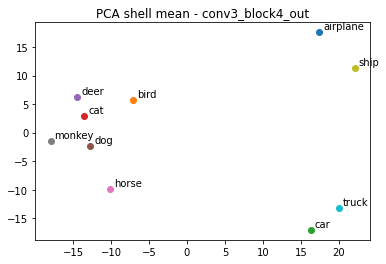

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


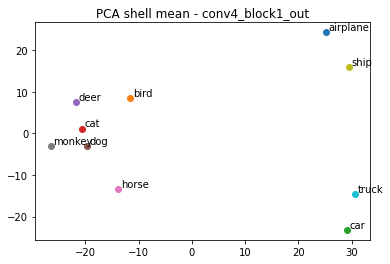

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


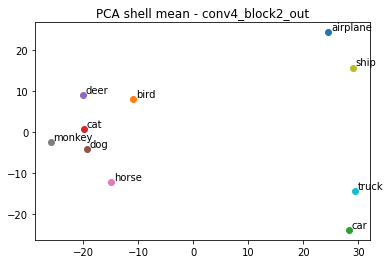

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


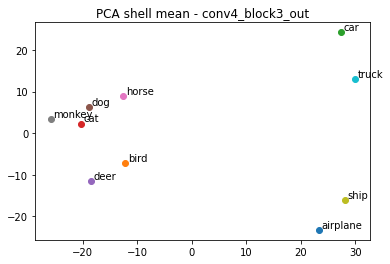

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


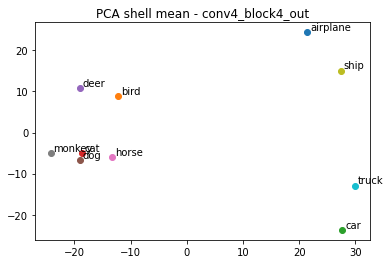

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


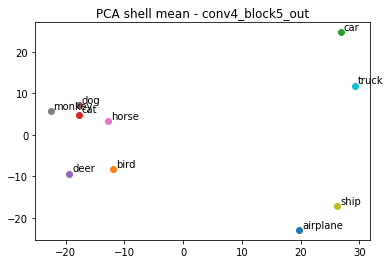

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


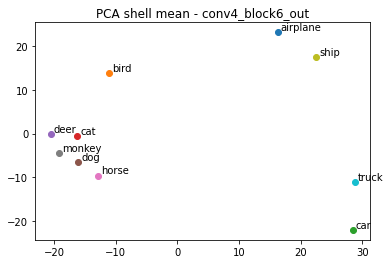

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


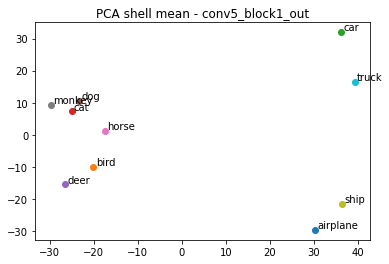

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


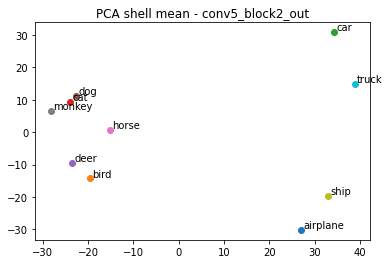

Found 5000 images with 10 classes!
Found 8000 images with 10 classes!


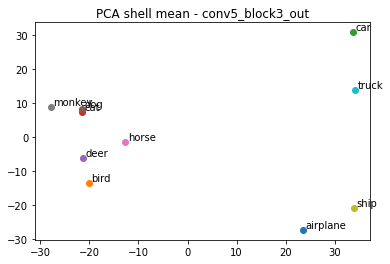

In [12]:
all_results = []
for conv_block in out_layer_index:
    shell_family = shell.ShellFamily()
    shell_family.create_preprocessor("resnet50")
    shell_family.preprocessor = extract_layers(shell_family.preprocessor.layers[0], 0, conv_block[0])
    train_image_generator = ImageGenerator(X_train, y_train, 2048, (224, 224))
    test_image_generator = ImageGenerator(X_test, y_test, 1, (224, 224))
    shell_family.fit(train_image_generator, train_classes, "../models/resnet_" + conv_block[1] + ".pkl")
    y_predict = []
    for processed_image_array, _, groundtruth in test_image_generator:
        sample_features = shell_family.preprocessor.predict(processed_image_array)
        class_index, class_name, score, full_results = shell_family.score(sample_features, 0.5, with_update=False, return_full_results=True)
        y_predict.append(class_index)
    y_predict = np.array(y_predict)
    json_results = classification_report(y_test, y_predict, output_dict=True)
    all_results.append(json_results)
    # Plot PCA
    mean_array = []
    noise_array = []
    for shell_classifier in shell_family.classifiers:
        mean_array.append(shell_family.classifiers[shell_classifier].shell_mean[0])
    scaler = StandardScaler()
    scaled_mean = scaler.fit_transform(mean_array)
    pca = PCA(n_components=2, random_state=42)
    transformed = pca.fit_transform(scaled_mean)
    for i in range(len(transformed)):
        plt.scatter(transformed[i, 0], transformed[i, 1])
        plt.text(transformed[i, 0] + 0.5, transformed[i, 1] + 0.5, shell_family.mapping[i])
    plt.title("PCA shell mean - " + conv_block[1])
    plt.show()

# Results Graph

In [13]:
precision = []
recall = []
f1 = []
for result in all_results:
    precision.append(result['macro avg']['precision'])
    recall.append(result['macro avg']['recall'])
    f1.append(result['macro avg']['f1-score'])

In [14]:
out_layer_names = [i[1] for i in out_layer_index]

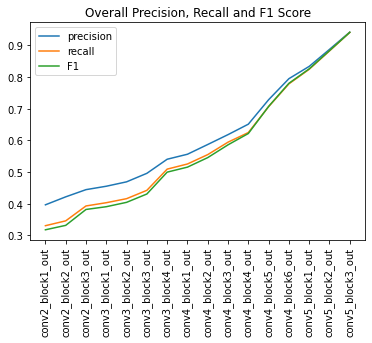

In [18]:
plt.plot(out_layer_names, precision, label="precision")
plt.plot(out_layer_names, recall, label="recall")
plt.plot(out_layer_names, f1, label="F1")
plt.title('Overall Precision, Recall and F1 Score')
plt.xticks(rotation=90)
plt.legend()
plt.show()